In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from random import seed,sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import metrics

In [2]:
data = pd.read_csv("fraud.csv")

In [3]:
df = data.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [4]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'], axis=1, inplace=True)
df = df.reset_index(drop=True)

In [6]:
df_new = df[(df["type"] == "CASH_OUT") | (df["type"] == "TRANSFER")]

In [7]:
df_new["type"]=df_new["type"].astype('category')

In [8]:
df_new.head(1)

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud
2,1,TRANSFER,181.0,181.0,0.0,0.0,0.0,1


In [9]:
df_pca=pd.get_dummies(df_new, columns=["type"])

In [9]:
df_pca = df_pca[["step", "amount","oldBalanceOrig","newBalanceOrig","oldBalanceDest","newBalanceDest","type_CASH_OUT","type_TRANSFER","isFraud"]]

In [10]:
df_pca.head(1)

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
2,1,181.0,181.0,0.0,0.0,0.0,1,0,1


In [11]:
from sklearn.model_selection import train_test_split
X,y=df_pca.iloc[:,:7].values, df_pca.iloc[:,8].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42,stratify=y)
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_test_std=std.transform(X_test)

In [12]:
import numpy as np
scov=np.cov(X_train_std.T)
eigen_vals, eigen_vecs=np.linalg.eig(scov)
print('Eigenvalues \n%s' %eigen_vals)

Eigenvalues 
[2.24245668 1.88655297 0.00807907 0.16900238 1.0310232  0.92767838
 0.73521093]


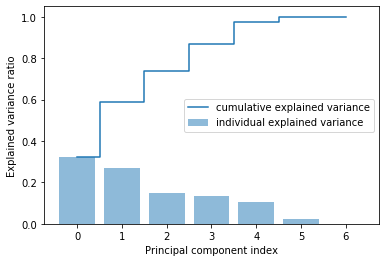

In [13]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(0,7), var_exp, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(0,7), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [14]:
from sklearn.decomposition import PCA
lpca = PCA(n_components=3)
X_train_pca = lpca.fit_transform(X_train_std)
X_test_pca = lpca.transform(X_test_std)

In [15]:
print(lpca.components_)
print(lpca.explained_variance_ratio_)

[[ 0.05233961  0.42687387  0.04830784  0.02245872  0.61808006  0.65522869
   0.02921684]
 [ 0.01130225  0.07115456  0.69234221  0.63036957 -0.07509974 -0.06374913
   0.32924434]
 [-0.81488323 -0.08455028  0.04397214  0.25372496  0.07716217  0.05788773
  -0.50319149]]
[0.32035079 0.26950743 0.14728895]


In [16]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train_pca, y_train)
y_train_pre=lr.predict(X_train_pca)
y_test_pre=lr.predict(X_test_pca)

In [17]:
print("PCA-Logistic Regression Accuracy",accuracy_score(y_train, y_train_pre),accuracy_score(y_test, y_test_pre))

PCA-Logistic Regression Accuracy 0.8094757555100176 0.8092231835721067


In [18]:
print(accuracy_score(y_train, y_train_pre)) 
print(accuracy_score(y_test, y_test_pre))
print(confusion_matrix(y_test, y_test_pre))

0.8094757555100176
0.8092231835721067
[[663840   7410]
 [151149   8724]]


In [19]:
print(classification_report(y_test,y_test_pre))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    671250
           1       0.54      0.05      0.10    159873

    accuracy                           0.81    831123
   macro avg       0.68      0.52      0.50    831123
weighted avg       0.76      0.81      0.74    831123



In [20]:
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(random_state=42, solver='lbfgs'))     

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10)
print('CV accuracy scores: %s' % scores)
import numpy as np
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.8097448  0.80932197 0.80891976 0.80983762 0.80920852 0.80960558
 0.80939833 0.80950146 0.80931067 0.80982117]
CV accuracy: 0.809 +/- 0.000


In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
cld=LinearDiscriminantAnalysis(store_covariance=True)
cld.fit(X_train, y_train)
y_train_pred=cld.predict(X_train)
y_test_pred=cld.predict(X_test)

In [42]:
print("LDA Accuracy",accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred))

LDA Accuracy 0.9979337756266997 0.9979629970533844


In [27]:
print(confusion_matrix(y_test, y_test_pred))

[[828491    168]
 [  1525    939]]


In [49]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(),
                     LinearDiscriminantAnalysis(store_covariance=True))  

In [50]:
scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.99782395 0.99792192 0.99808177 0.99794255 0.99796833 0.99788067
 0.99792192 0.99787034 0.99794254 0.99799409]
CV accuracy: 0.998 +/- 0.000


In [43]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.85      0.38      0.53      2464

    accuracy                           1.00    831123
   macro avg       0.92      0.69      0.76    831123
weighted avg       1.00      1.00      1.00    831123



In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda=LDA(n_components=3) 
X_train_lda=lda.fit_transform(X_train_std,y_train)
X_test_lda=lda.transform(X_test_std) 
lr=LogisticRegression()
lr.fit(X_train_lda, y_train)
y_train_pred=lr.predict(X_train_lda)
y_test_pred=lr.predict(X_test_lda)

In [40]:
print("LDA-Logistic Regression Accuracy",accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred))

LDA-Logistic Regression Accuracy 0.9979188216694186 0.9979461523745583


In [32]:
print(confusion_matrix(y_test, y_test_pred))

[[828465    194]
 [  1513    951]]


In [38]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.83      0.39      0.53      2464

    accuracy                           1.00    831123
   macro avg       0.91      0.69      0.76    831123
weighted avg       1.00      1.00      1.00    831123



In [33]:
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
                        LDA(n_components=3),
                        LogisticRegression(random_state=42, solver='lbfgs'))     

In [98]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10)
print('CV accuracy scores: %s' % scores)
import numpy as np
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.99779816 0.99790645 0.9980663  0.99791676 0.99794255 0.9978652
 0.99789614 0.99788581 0.99793222 0.99797346]
CV accuracy: 0.998 +/- 0.000


In [51]:
parametersRF = {'n_estimators':15,'oob_score':True,'class_weight': "balanced",'n_jobs':-1,'random_state':42}
RF = RandomForestClassifier(**parametersRF)
RF.fit(X_train, y_train)
y_train_pred=RF.predict(X_train)
y_test_pred = RF.predict(X_test)

In [52]:
print("Random Forest Accuracy",accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

Random Forest Accuracy 0.9999623572799473 0.9992708660450981
[[828600     59]
 [   547   1917]]


In [47]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(),
                        RandomForestClassifier(**parametersRF))     

In [48]:
scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.99929871 0.99925746 0.99927809 0.9992884  0.99934512 0.99926262
 0.99938637 0.99920073 0.99927808 0.99928839]
CV accuracy: 0.999 +/- 0.000


In [36]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.97      0.78      0.86      2464

    accuracy                           1.00    831123
   macro avg       0.98      0.89      0.93    831123
weighted avg       1.00      1.00      1.00    831123



In [10]:
from sklearn.model_selection import GridSearchCV
param= {'max_depth': range (2, 5,1),'learning_rate': [0.1, 0.01]}
xgsearch=GridSearchCV(estimator = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42),param_grid=param,scoring = 'roc_auc', n_jobs = 10, cv = 10)
xgsearch.fit(X_train,y_train)
xgsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 4}

In [22]:
xgb_model = XGBClassifier(max_depth=4,seed=17,learning_rate=0.1,random_state=42)
xgb_model.fit(X_train, y_train)
y_train_pred=xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [59]:
print("XGB Accuracy",accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

XGB Accuracy 0.9992254881435745 0.9992107064778619
[[828632     27]
 [   629   1835]]


In [60]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.99      0.74      0.85      2464

    accuracy                           1.00    831123
   macro avg       0.99      0.87      0.92    831123
weighted avg       1.00      1.00      1.00    831123



In [12]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(),
                        XGBClassifier(max_depth=3,seed=17,learning_rate=0.1,random_state=42))     

In [14]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.99927293 0.9991698  0.99921621 0.99918011 0.99926262 0.9991698
 0.99928324 0.99912339 0.99913886 0.99923167]
CV accuracy: 0.999 +/- 0.000


In [25]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=1)
dtc.fit(X_train, y_train)
y_train_pred = dtc.predict(X_train)  
y_test_pred = dtc.predict(X_test) 

[Text(167.4, 190.26, 'X[1] <= 543357.562\nentropy = 0.311\nsamples = 1939286\nvalue = [1566250, 373036]'),
 Text(83.7, 135.9, 'X[1] <= 360427.266\nentropy = 0.204\nsamples = 1744558\nvalue = [1543047, 201511]'),
 Text(41.85, 81.53999999999999, 'X[1] <= 242091.461\nentropy = 0.171\nsamples = 1564712\nvalue = [1417046, 147666]'),
 Text(20.925, 27.180000000000007, 'entropy = 0.151\nsamples = 1264914\nvalue = [1161156, 103758]'),
 Text(62.775000000000006, 27.180000000000007, 'entropy = 0.25\nsamples = 299798\nvalue = [255890, 43908]'),
 Text(125.55000000000001, 81.53999999999999, 'X[1] <= 459702.672\nentropy = 0.42\nsamples = 179846\nvalue = [126001, 53845]'),
 Text(104.625, 27.180000000000007, 'entropy = 0.377\nsamples = 123539\nvalue = [92361, 31178]'),
 Text(146.475, 27.180000000000007, 'entropy = 0.481\nsamples = 56307\nvalue = [33640, 22667]'),
 Text(251.10000000000002, 135.9, 'X[1] <= 669706.906\nentropy = 0.21\nsamples = 194728\nvalue = [23203, 171525]'),
 Text(209.25, 81.5399999999

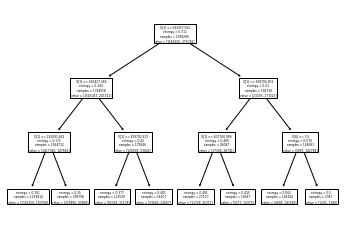

In [26]:
tree.plot_tree(dtc.fit(X_train,y_train))

In [27]:
print("Decision Tree Accuracy",accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred))
print(metrics.confusion_matrix(y_test, y_test_pred))

Decision Tree Accuracy 0.8841331294094837 0.8837308075940625
[[661641   9609]
 [ 87025  72848]]


In [12]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.82      0.65      0.73      2464

    accuracy                           1.00    831123
   macro avg       0.91      0.83      0.86    831123
weighted avg       1.00      1.00      1.00    831123



In [15]:
from sklearn import tree
pipe = make_pipeline(StandardScaler(),
                        tree.DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=1))     

In [16]:
scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.99858711 0.99858196 0.99859742 0.99862321 0.99859742 0.99846336
 0.99865415 0.99841178 0.99839116 0.99856647]
CV accuracy: 0.999 +/- 0.000
